# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Построим модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Описание данных

**Признаки**

`DateCrawled` — дата скачивания анкеты из базы<br>
`VehicleType` — тип автомобильного кузова<br>
`RegistrationYear` — год регистрации автомобиля<br>
`Gearbox` — тип коробки передач<br>
`Power` — мощность (л. с.)<br>
`Model` — модель автомобиля<br>
`Kilometer` — пробег (км)<br>
`RegistrationMonth` — месяц регистрации автомобиля<br>
`FuelType` — тип топлива<br>
`Brand` — марка автомобиля<br>
`Repaired` — была машина в ремонте или нет<br>
`DateCreated` — дата создания анкеты<br>
`NumberOfPictures` — количество фотографий автомобиля<br>
`PostalCode` — почтовый индекс владельца анкеты (пользователя)<br>
`LastSeen` — дата последней активности пользователя<br>

**Целевой признак**

`Price` — цена (евро)

## Основные шаги:
- Загрузим данные.
- Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.
- Подготовим выборки для обучения моделей.
- Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
- Проанализируем время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle
from collections import defaultdict

Откроем файл и изучим данные.

In [2]:
df = pd.read_csv('autos.csv')

In [3]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
213658,2016-03-05 22:41:27,250,small,1997,manual,0,1_reihe,90000,3,petrol,peugeot,no,2016-03-05 00:00:00,0,15234,2016-03-07 05:44:15
44907,2016-03-10 19:39:32,0,small,2007,manual,67,getz,125000,3,petrol,hyundai,no,2016-03-10 00:00:00,0,18055,2016-04-06 02:17:30
140585,2016-03-14 19:45:25,1250,NaN,2000,manual,170,3er,150000,0,petrol,bmw,NaN,2016-03-14 00:00:00,0,24114,2016-03-17 09:17:14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Можно заметить аномальные мин/макс показатели в признаках Price, RegistrationYear, Power

Сразу удалим признаки которые явно не влияют на предсказания цены.

In [6]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'])

In [7]:
df.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954


In [8]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

Проверим данные на пропуски.

In [9]:
def show_na(df):
    count = (df.isna() | df.isnull()).sum()
    percent = round(count / df.shape[0], 3) * 100
    res = pd.concat([count, percent], axis=1,  keys=['count', 'percent, %'])\
           .sort_values('count', ascending=False)
    return res

show_na(df)

,count,"percent, %"
Repaired,71154,20.1
VehicleType,37490,10.6
FuelType,32895,9.3
Gearbox,19833,5.6
Model,19705,5.6
Price,0,0.0
RegistrationYear,0,0.0
Power,0,0.0
Kilometer,0,0.0
RegistrationMonth,0,0.0


Проверим на уникальность и неявные дубликаты.

In [10]:
for col in cat_col:
    print(col, '\n', df[col].unique())

VehicleType 
 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox 
 ['manual' 'auto' nan]
Model 
 ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' '

Пропуски в категории Repaired можно заменить на no, вероятно если машина не была в ремонте, то владелец и не указывал ничего. Остальные пропуски в категориальных признаках можно заменить на "uncknow".

In [11]:
df['Repaired'] = df['Repaired'].fillna('no')
df[cat_col] = df[cat_col].fillna('unknown')

In [12]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

После замены пропусков проверим на дубликаты и удалим их, если есть.

In [13]:
df.duplicated().sum()

23697

In [14]:
df = df.drop_duplicates()

In [15]:
df.duplicated().sum()

0

In [16]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,no,70435
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


Проверим распределения данных.

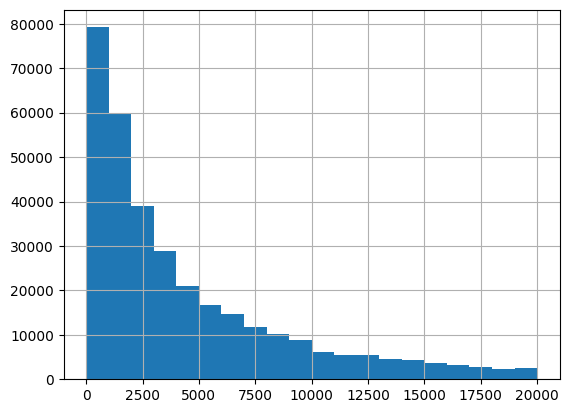

In [17]:
_ = df['Price'].hist(bins=20)

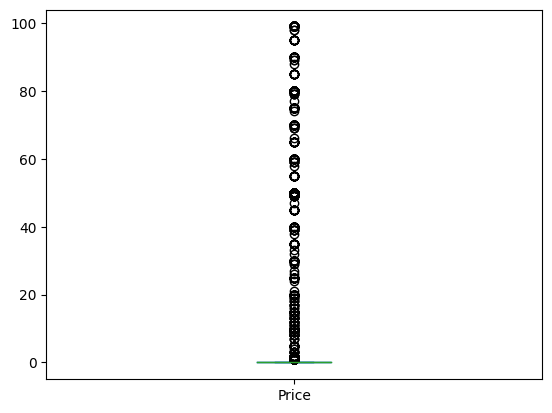

In [18]:
_ = df[df['Price'] < 100]['Price'].plot.box()

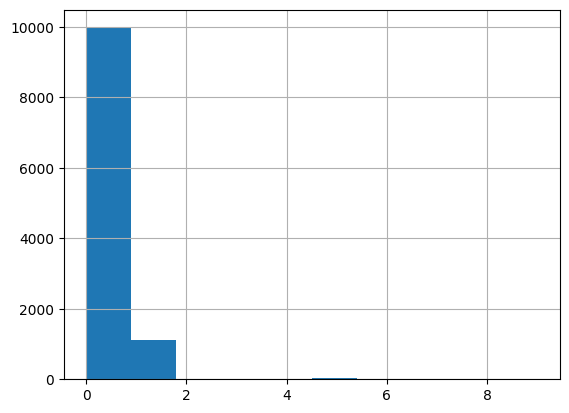

In [19]:
_ = df[df['Price'] < 10]['Price'].hist(bins=10)

В данных присутствуют цены с минимальными значениями. Особенно 0 и 1, возможно это ошибка или машины на металлолом за самовывоз. Эти данные никак не помогут нам в предсказании цены, избавимся от них.

In [20]:
df = df[df['Price'] > 1]

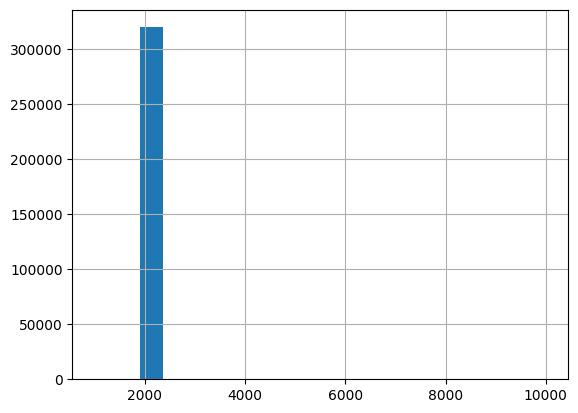

In [21]:
_ = df['RegistrationYear'].hist(bins=20)

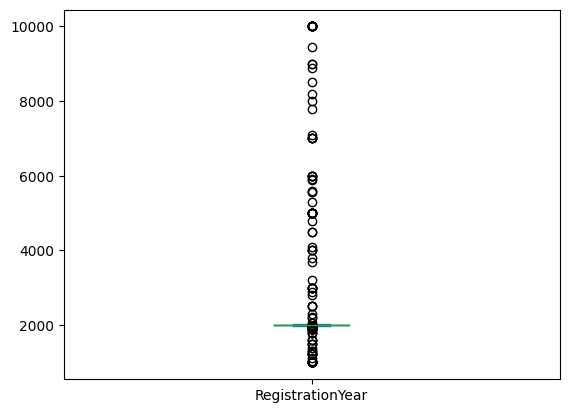

In [22]:
_ = df['RegistrationYear'].plot.box()

Оставим более логичные и реальные данные по годам регистрации.

In [23]:
df['RegistrationYear'].quantile(.001)

1960.0

In [24]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1950)]

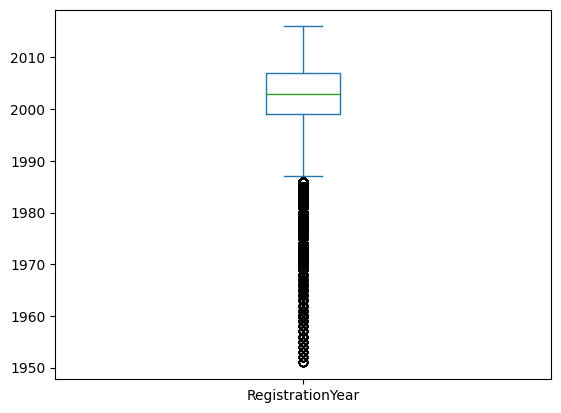

In [25]:
_ = df['RegistrationYear'].plot.box()

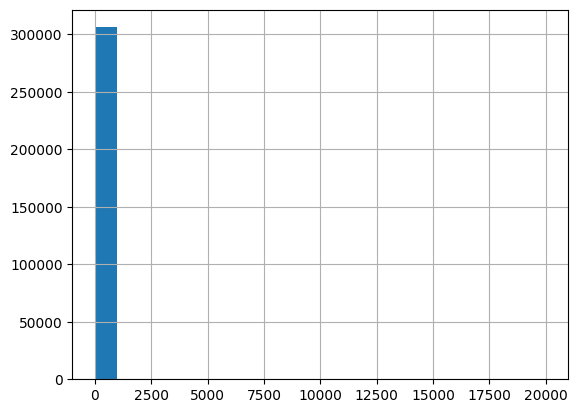

In [26]:
_ = df['Power'].hist(bins=20)

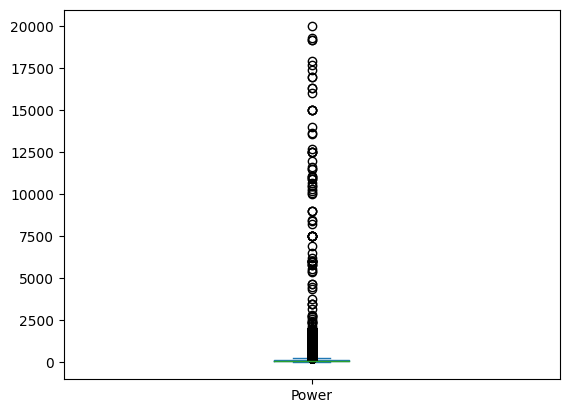

In [27]:
_ = df['Power'].plot.box()

In [28]:
df['Power'].quantile(.999)

617.6960000004619

Аналогично, удалим аномальные и очень редкие данные

In [29]:
df = df[df['Power'] <= 750]

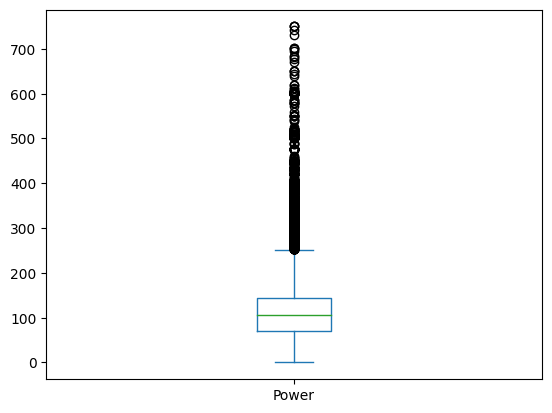

In [30]:
_ = df['Power'].plot.box()

Переведем категориальные данные в тип 'category'

In [31]:
for col in cat_col:
    df[col] = df[col].astype('category')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306002 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              306002 non-null  int64   
 1   VehicleType        306002 non-null  category
 2   RegistrationYear   306002 non-null  int64   
 3   Gearbox            306002 non-null  category
 4   Power              306002 non-null  int64   
 5   Model              306002 non-null  category
 6   Kilometer          306002 non-null  int64   
 7   RegistrationMonth  306002 non-null  int64   
 8   FuelType           306002 non-null  category
 9   Brand              306002 non-null  category
 10  Repaired           306002 non-null  category
 11  PostalCode         306002 non-null  int64   
dtypes: category(6), int64(6)
memory usage: 18.4 MB


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306002 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              306002 non-null  int64   
 1   VehicleType        306002 non-null  category
 2   RegistrationYear   306002 non-null  int64   
 3   Gearbox            306002 non-null  category
 4   Power              306002 non-null  int64   
 5   Model              306002 non-null  category
 6   Kilometer          306002 non-null  int64   
 7   RegistrationMonth  306002 non-null  int64   
 8   FuelType           306002 non-null  category
 9   Brand              306002 non-null  category
 10  Repaired           306002 non-null  category
 11  PostalCode         306002 non-null  int64   
dtypes: category(6), int64(6)
memory usage: 18.4 MB


Разделим данные на признаки и целевой признак. Разделим датасет на обучающую и тестовую выборку размером 75 на 25. И обучающую еще на 75/25 для валидационной.

In [34]:
X = df.drop(['Price'], axis=1)
y = df['Price']

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=33)

Преобразуем категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding, OHE) для модели LinearRegression

In [35]:
X_ohe_train = pd.get_dummies(X_train, drop_first=True).copy()
X_ohe_valid = pd.get_dummies(X_valid, drop_first=True).copy()
X_ohe_test = pd.get_dummies(X_test, drop_first=True).copy()

In [36]:
X_train.head(3)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
204557,bus,2008,auto,116,unknown,150000,9,gasoline,sonstige_autos,no,60388
11685,small,1998,manual,45,polo,150000,4,petrol,volkswagen,no,25364
318755,unknown,2016,manual,0,unknown,5000,4,petrol,renault,no,44795


In [37]:
X_ohe_train.head(3)

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
204557,2008,116,150000,9,60388,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11685,1998,45,150000,4,25364,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
318755,2016,0,5000,4,44795,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Подберем параметры для моделей.

Посмотрим на дисперсию и нормализуем данные.

In [38]:
num_col = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

In [39]:
X_train[num_col].var()

RegistrationYear     4.587745e+01
Power                3.944441e+03
Kilometer            1.398529e+09
RegistrationMonth    1.350212e+01
PostalCode           6.646693e+08
dtype: float64

In [40]:
scaler = StandardScaler()
scaler.fit(X_train.loc[:, num_col])

X_train.loc[:, num_col] = scaler.transform(X_train.loc[:, num_col])
X_valid.loc[:, num_col] = scaler.transform(X_valid.loc[:, num_col])
X_test.loc[:, num_col] = scaler.transform(X_test.loc[:, num_col])

X_ohe_train.loc[:, num_col] = scaler.transform(X_ohe_train.loc[:, num_col])
X_ohe_valid.loc[:, num_col] = scaler.transform(X_ohe_valid.loc[:, num_col])
X_ohe_test.loc[:, num_col] = scaler.transform(X_ohe_test.loc[:, num_col])

In [41]:
X_train[num_col].var()

RegistrationYear     1.000006
Power                1.000006
Kilometer            1.000006
RegistrationMonth    1.000006
PostalCode           1.000006
dtype: float64

In [42]:
X_ohe_valid[num_col].var()

RegistrationYear     1.001440
Power                1.003705
Kilometer            1.009871
RegistrationMonth    1.008988
PostalCode           1.006161
dtype: float64

In [43]:
X_train.head(3)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
204557,bus,0.798669,auto,0.123924,unknown,0.578034,0.872818,gasoline,sonstige_autos,no,0.366028
11685,small,-0.677723,manual,-1.006566,polo,0.578034,-0.487907,petrol,volkswagen,no,-0.992486
318755,unknown,1.979782,manual,-1.723074,unknown,-3.299303,-0.487907,petrol,renault,no,-0.238795


In [44]:
X_ohe_valid.head(3)

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
243630,0.208112,1.748009,0.578034,1.144963,1.212501,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
307855,-0.087167,0.362760,0.578034,-1.032197,-0.127977,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27193,-1.268280,-0.528894,0.578034,0.600673,-0.950712,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### Вывод
- Загрузили и изучили данные.
- Удалили признаки которые явно не влияют на предсказания цены.
- Проверили данные на пропуски, уникальность и неявные дубликаты
- Пропуски в категории Repaired заменили на no, вероятно если машина не была в ремонте, то владелец не указывал ничего. Остальные пропуски в категориальных признаках заменили на "uncknow".
- Проверили распределения данных.
Оставили более логичные и реальные данные по годам регистрации: 1950 - 2023. Аналогично, удалили аномальные и очень редкие данные мощности авто: 750+
- Перевели категориальные данные в тип 'category'. Нормализовали численные данные.
- Разделили данные на обучающую, валидационную и тестовую выборки.
- Нормализовали численные данные.

## Обучение моделей

#### 1. CatBoost

In [45]:
%%time
model_cbr = CatBoostRegressor(cat_features=cat_col, silent=True)

params = {
    'learning_rate': [0.1, 0.2, 0.4],
    'iterations': [80, 200],
    'depth': [8, 10],
}

grid_cbr = GridSearchCV(model_cbr,
                        params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        n_jobs=-1)

grid_cbr.fit(X_train, y_train)

CPU times: total: 3min 11s
Wall time: 4min


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001DE423FD930>,
             n_jobs=-1,
             param_grid={'depth': [8, 10], 'iterations': [80, 200],
                         'learning_rate': [0.1, 0.2, 0.4]},
             scoring='neg_mean_squared_error')

In [46]:
grid_cbr.best_params_

{'depth': 10, 'iterations': 200, 'learning_rate': 0.2}

#### 2. LightGBM

In [47]:
%%time
model_gbm = LGBMRegressor()

params = {
    'learning_rate': [0.1, 0.2, 0.4],
    'n_estimators': [80, 200],
    'max_depth': [10],
    'num_leaves': [11, 21, 41],
}

grid_gbm = GridSearchCV(model_gbm,
                        params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        verbose=True)
grid_gbm.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: total: 3min 40s
Wall time: 19 s


GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.4], 'max_depth': [10],
                         'n_estimators': [80, 200],
                         'num_leaves': [11, 21, 41]},
             scoring='neg_mean_squared_error', verbose=True)

In [48]:
grid_gbm.best_params_

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 41}

#### 3. LinearRegression

В линейной регрессии нет особых параметров для подбора, оставим по дефолту.

In [49]:
model_lreg = LinearRegression()

## Анализ моделей

Напишем функцию для расчета времени обучения, предсказания и скоринга.

In [50]:
def model_info(model, X_train, y_train, X_test, y_test):
    start = time.time()    
    model.fit(X_train, y_train)
    training_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start

    return training_time, predict_time, mse(y_test, y_pred)**0.5

Проведем тесты на валидационных данных и составим таблицу с информацией.

In [51]:
%%time
results = []
results.append(model_info(grid_cbr.best_estimator_, X_train, y_train, X_valid, y_valid))
results.append(model_info(grid_gbm.best_estimator_, X_train, y_train, X_valid, y_valid))
results.append(model_info(model_lreg, X_ohe_train, y_train, X_ohe_valid, y_valid))

CPU times: total: 3min 48s
Wall time: 30.7 s


In [52]:
columns = ['training_time','predict_time','RMSE']
index = ['CatBoost', 'LightGBM', 'LinearReg']
pd.DataFrame(results, columns=columns, index=index).sort_values(by='RMSE')

,training_time,predict_time,RMSE
LightGBM,0.518001,0.074002,1597.593069
CatBoost,25.898109,0.047000,1601.513775
LinearReg,4.067749,0.061510,2697.413963


Как видно из данных, модели градиентного бустинга показывают лучшие результаты в отличии от линейной регрессии.
CatBoost и LightGBM имеют почти одинаковые показатели RMSE и маленькую скорость предсказания. Однако у CatBoost очень большое время обучения относительно LightGBM.

Очевидно лучшая модель скорость/качество на данном наборе данных это LightGBM.

## Тестирование лучшей модели

Проверим модель LightGBM на тестовых данных:

In [53]:
final_pred = grid_gbm.best_estimator_.predict(X_test)

print('Модель LightGBM, RMSE:', mse(y_test, final_pred)**0.5)

Модель LightGBM, RMSE: 1619.2794282522207


На тестовых данных результат получили даже немного лучше, чем на валидационных.